## Download the original BigVGAN repo

In [1]:
%%bash
wget https://github.com/NVIDIA/BigVGAN/archive/refs/tags/v2.4.tar.gz --quiet
tar -xf v2.4.tar.gz && rm v2.4.tar.gz

In [2]:
!uv pip install -q -r BigVGAN-2.4/requirements.txt -i "https://mirrors.aliyun.com/pypi/simple/"

In [26]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


## Load the original BigVGAN pretrained model

In [ ]:
import sys
import numpy as np
sys.path.append("BigVGAN-2.4")


from bigvgan import BigVGAN

model = BigVGAN.from_pretrained("nvidia/bigvgan_v2_24khz_100band_256x")
# remove weight norm in the model and set to eval mode
model.remove_weight_norm()
model = model.eval().to("mps")


Loading weights from nvidia/bigvgan_v2_24khz_100band_256x
Removing weight norm...


### Convert the BigVGAN model to MLX format

repo id: [`nvidia/bigvgan_v2_24khz_100band_256x`](https://huggingface.co/nvidia/bigvgan_v2_24khz_100band_256x)


In [ ]:
!python -m mlx_bigvgan.convert --repo_id nvidia/bigvgan_v2_24khz_100band_256x

Model has been saved to mlx_models/bigvgan_v2_24khz_100band_256x.
To upload the model after conversion:
python -m mlx_bigvgan.convert --upload_repo <username>/<repo_name> ...


In [28]:
from mlx_bigvgan import BigVGAN as mlx_BigVGAN
import mlx.core  as mx
mlx_model = mlx_BigVGAN.from_pretrained("mlx_models/bigvgan_v2_24khz_100band_256x")
mx.eval(mlx_model.parameters())

## Load Test wav file

In [29]:
import librosa

wav_path = "test/Female_24khz.wav"
wav, sr = librosa.load(
    wav_path, sr=24000, mono=True
)  # wav is np.ndarray with shape [T_time] and values in [-1, 1]
wav.shape, wav.dtype, wav.min(), wav.max()

((145200,), dtype('float32'), np.float32(-0.34707642), np.float32(0.35058594))

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_waveform(
    waveform: np.ndarray,
    sample_rate: int,
    title,
    plot_width=8,
    plot_height=4,
):
    """
    Plot the waveform and spectrogram of the audio signal.
    Args:
        waveform (np.ndarray): The audio signal to plot.
        sample_rate (int): The sample rate of the audio signal.
    """
    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels * 2, 1, figsize=(plot_width, plot_height * num_channels))
    wav_axes = axes[:num_channels]
    wavspec_axes = axes[num_channels:]
    # spec_axes = axes[num_channels * 2 :]

    for c in range(num_channels):
        wav_axes[c].plot(time_axis, waveform[c], linewidth=1)
        wav_axes[c].set_xlim([0, time_axis[-1]])
        wav_axes[c].grid(True)
        wavspec_axes[c].specgram(waveform[c] + 1e-10, Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()


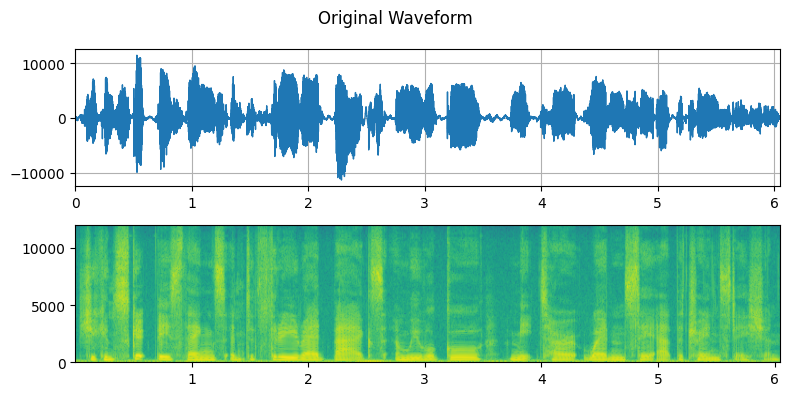

In [31]:
# show audio waveform
loaded_wav = (wav*32768.0).astype(np.int16)
loaded_wav = loaded_wav[None, :]
plot_waveform(loaded_wav, sr, "Original Waveform", plot_width=8, plot_height=4)

In [32]:
from IPython.display import Audio
Audio(loaded_wav, rate=sr)

## Compute mel spectrogram from the ground truth audio

In [33]:
h = model.h
print(
    "Mel spectrogram config:\n",
    "n_fft=", h.n_fft,
    "num_mels=", h.num_mels,
    "sampling_rate=", h.sampling_rate,
    "hop_size=", h.hop_size,
    "win_size=", h.win_size,
    "fmin=", h.fmin,
    "fmax=", h.fmax,
)

Mel spectrogram config:
 n_fft= 1024 num_mels= 100 sampling_rate= 24000 hop_size= 256 win_size= 1024 fmin= 0 fmax= None


In [34]:
import torch
from meldataset import get_mel_spectrogram
torch_wav = torch.tensor(wav).to(torch.float32).unsqueeze(0)  # shape [B(1), T_time]

mel_spec = get_mel_spectrogram(torch_wav, model.h)  #[B(1), C_mel, T_frame]
mel_spec.shape, mel_spec.dtype, mel_spec.min(), mel_spec.max()

(torch.Size([1, 100, 567]), torch.float32, tensor(-10.8401), tensor(0.4149))

In [35]:
from mlx_bigvgan.audio import log_mel_spectrogram as my_mel_spectrogram

my_mel_spec = my_mel_spectrogram(
    wav,
    n_fft=h.n_fft,
    n_mels=h.num_mels,
    sample_rate=h.sampling_rate,
    hop_length=h.hop_size,
    fmin=h.fmin,
    fmax=h.fmax,
    padding=(h.n_fft - h.hop_size) // 2,
    mel_norm="slaney",
    mel_scale="slaney",
    power=1.0,
)
# #[T_frame, C_mel]
my_mel_spec.shape, my_mel_spec.dtype, my_mel_spec.min(), my_mel_spec.max()

((571, 100),
 mlx.core.float32,
 array(-10.8437, dtype=float32),
 array(0.414882, dtype=float32))

### Comapre the computed mel spectrogram with the original

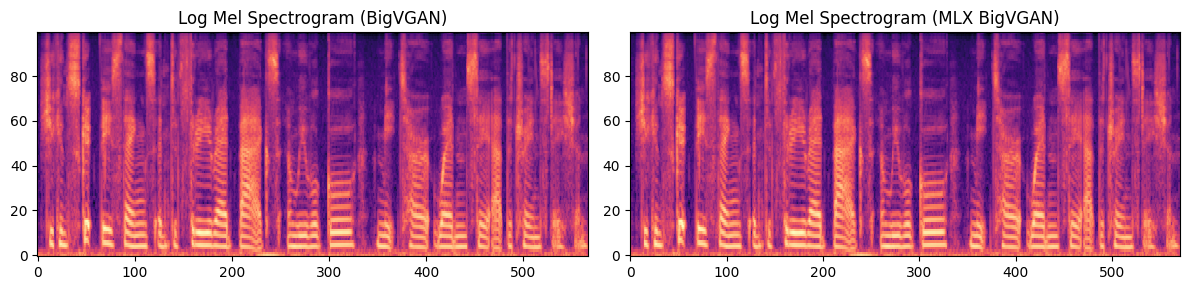

In [37]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(
    mel_spec.squeeze(0).numpy(),
    aspect="auto",
    origin="lower",
    interpolation="none",
    cmap="magma",
)
plt.title("Log Mel Spectrogram (BigVGAN)")
plt.subplot(1, 2, 2)
plt.imshow(
    my_mel_spec.T,
    aspect="auto",
    origin="lower",
    interpolation="none",
    cmap="magma",
)
plt.title("Log Mel Spectrogram (MLX BigVGAN)")
plt.tight_layout()
plt.show()


## Generate waveform from mel by BigVGAN

1. Using the original BigVGAN

In [38]:
with torch.inference_mode():
    wav_gen = model(mel_spec.to("mps"))
#[B(1), 1, T_time] and values in [-1, 1]
print(wav_gen.shape, wav_gen.dtype, wav_gen.min(), wav_gen.max())
wav_gen_float = wav_gen.squeeze(0).cpu()  # wav_gen is FloatTensor with shape [1, T_time]
wav_gen_float.shape


torch.Size([1, 1, 145152]) torch.float32 tensor(-0.3991, device='mps:0') tensor(0.3174, device='mps:0')


torch.Size([1, 145152])

2. Using the MLX BigVGAN

In [40]:
mel_spec2 = mx.expand_dims(my_mel_spec, 0)  # [1, T_frame, C_mel]
wav_gen2 = mlx_model(mel_spec2)
print(wav_gen2.shape, wav_gen2.dtype, wav_gen2.min(), wav_gen2.max())
wav_gen2_float = wav_gen2.squeeze(0).T  # [1, T_time]
wav_gen2_float.shape

(1, 146176, 1) mlx.core.float32 array(-0.398892, dtype=float32) array(0.317455, dtype=float32)


(1, 146176)

### Compare the generated waveform

In [41]:
import numpy as np
wav_gen_int16 = (wav_gen_float * 32767.0).numpy().astype("int16")
wav_gen2_int16 = np.array((wav_gen2_float * 32767.0).astype(mx.int16), copy=False)


1. Generated wav from the original BigVGAN

In [42]:
Audio(wav_gen_int16, rate=h.sampling_rate)

2. Generated wav from the MLX BigVGAN

In [43]:
Audio(wav_gen2_int16, rate=h.sampling_rate)

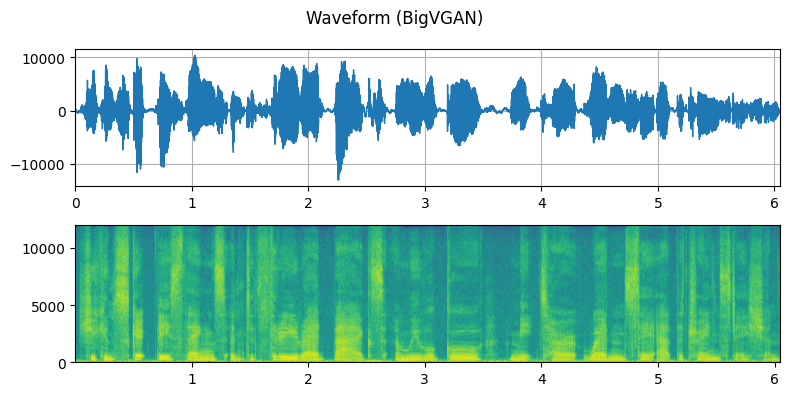

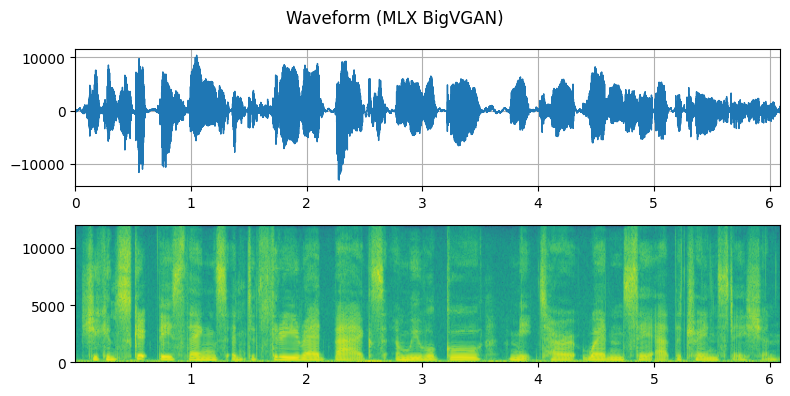

In [44]:
plot_waveform(wav_gen_int16, h.sampling_rate, "Waveform (BigVGAN)")
plot_waveform(wav_gen2_int16, h.sampling_rate, "Waveform (MLX BigVGAN)")
